In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mplpatches
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import numpy as np
import sys
import time
from collections import defaultdict
sys.path.insert(0, '/private/groups/brookslab/gabai/tools/seqUtils/src/')
from seqUtil import *
from nanoUtil import *
from bamUtil import *
from nntUtil import *
from plotUtil import *
from trackUtil import *

In [4]:
class findNemo:

    '''
    class findNemo: predict small molecule modifications from nanopore long-read sequencing data.
    '''
    
    def __init__(self, region, bam, genome, outpath, prefix, eventalign, sigalign, step):
        
        '''
        self:
            self.alignment: dict, stores reference an reads mapped to region.
            self.chrom: str, chromosome name.
            self.qStart: int, query start position.
            self.qEnd: int, query end position
            self.outpath: str, path to store the output files.
        Input:
            region: genomic coordinates to perform modification predictions. Format: 'chrI:2000-5000' or 'chrI'.
            bam: sorted, indexed, and binarized alignment file.
            genome: reference genome fasta file.
        Output:
            outpath: path to store the output files.
            prefix: prefix of output file names.
            eventalign: nanopolish eventalign file.
            sigalign: sigalign file if sigAlign file already exist. If not, must provide eventalign to generate sigAlign file.
        '''

        # Fetch reads aligned to the region
        print('Collecting reads mapped to ', region, ' ...')
        self.region = region
        self.alignment, self.chrom, self.qStart, self.qEnd = getAlignedReads(bam, region, genome)
        self.outpath = outpath
        self.prefix = prefix
        self.step = step
        self.bins = np.arange(self.qStart, self.qEnd, self.step)

        # Index reads to avoid storing the long readnames. 
        self.reads = {r:i for r,i in zip(self.alignment, range(len(self.alignment)))}
        self.alignment = {self.reads[r]:self.alignment[r] for r in self.reads}

        # Store the id index match into a file.
        readFh = open(outpath + prefix + '_' + region + '_readID.tsv', 'w')
        for k,v in self.reads.items(): readFh.write('{read}\t{index}\n'.format(read = k, index = v))
        readFh.close()
        print(len(self.reads), " reads mapped to ", region)

        if sigalign:
            self.sigalign = sigalign
        elif eventalign:
            self.sigalign = outpath + prefix + '_' + str(region) + '_sig.tsv'
            parseEventAlign(eventAlign = eventalign, reads = self.reads, outfile = self.sigalign)
        else:
            print('None of sigalign or eventalign file is provided.')
        
        self.gene_regions = {
            'PHO5': 'chrII:429000-435000',
            'CLN2': 'chrXVI:66000-67550',
            'HMR': 'chrIII:290000-299000',
            'AUA1': 'chrVI:114000-116000',
            'EMW1': 'chrXIV:45000-50000',
            'NRG2': 'chrII:370000-379000',
            'RDN37': 'chrXII:450300-459300'
            }

    def doWork(self, work):
        (readID, strand, bins, step, aStart, aEnd, sigList, sigLenList, kmerWindow, signalWindow, device, model, weight) = work
        
        scores = runNNT(readID, strand, bins, step, aStart, aEnd, sigList, sigLenList, kmerWindow, signalWindow, device, model, weight)
        
        return scores
    
    def modPredict(self, model, weight, threads, kmerWindow, signalWindow, load):
        
        print('Start predicting modified positions...')
        torch.multiprocessing.set_start_method('spawn')
                
        device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
        
        # only one model available
        models = {
            'resnet1d': ResNet1D(
                in_channels=1,
                base_filters=128,
                kernel_size=3,
                stride=2,
                groups=1,
                n_block=8,
                n_classes=2,
                downsample_gap=2,
                increasefilter_gap=4,
                use_do=False)
            }
        
        print('Device type: ', device)
        
        # Total work to be done are stored in a list
        works = [(readID, strand, self.bins, self.step, aStart, aEnd, sigList, sigLenList, kmerWindow, signalWindow, device, models[model], weight) 
                  for readID, aStart, aEnd, strand, sigList, sigLenList in parseSigAlign(self.sigalign, self.alignment)]
        
        # Use the specified threads number or maximum available CPU cores
        num_processes = min(threads, multiprocessing.cpu_count())
        
        for x in range(0, len(works), load):
            # split total work by loads
            works_per_load = works[x:x+load]
            # open the pool for multiprocessing
            pool = multiprocessing.Pool(processes=num_processes)
            # Use the pool.map() function to process reads in parallel
            outs = pool.map(self.doWork, works_per_load)

            # Close the pool to release resources
            pool.close()
            pool.join()

            # Write the results from current work load
            predOut = self.outpath + self.prefix + '_'  + str(self.region) + '_' + str(x) + '_prediction.tsv'
            predOutFh = open(predOut, 'w')
            for r in range(len(outs)):
                out = outs[r]
                readID = works_per_load[r][0]
                strand = works_per_load[r][1]
                bin_start = next(iter(out))
                predOutFh.write('{readID}\t{strand}\t{bin_start}\t{scores}\n'.format(readID = readID, strand = strand, bin_start = bin_start, scores = ','.join(map(str, out.values()))))
            predOutFh.close()
            print('Prediction scores were writted in ',predOut, '.')
    
    def predToBedGraph(self, prediction, threashold):
        
        bdgOut = self.outpath + self.prefix + '_'  + str(self.region) + '_' + str(threashold) + '_prediction.bedgraph'
        print('Writing summarized prediction output to ', bdgOut, '...')
        predictionToBedGraph(prediction, self.bins, self.step, threashold, self.chrom, self.qStart, 
                     self.qEnd, self.prefix, outfile=bdgOut)
        print('Done exporitng bedgraph.')
    
    def plotTrack(self, prediction, gtfFile, refBdg, predBdg, pregion, threashold):
        if pregion in self.gene_regions:
            myregion = self.gene_regions[pregion]
        else:
            myregion = pregion
        myplot = plotAllTrack(prediction, gtfFile, refBdg, predBdg, myregion, self.bins, self.step, self.outpath, self.prefix, threashold)
        outfig =  self.outpath + self.prefix + '_'  + str(myregion) + '_modTrack.png'
        print('Saving output to ', outfig)
        myplot.savefig(outfig)
        print('Done plotting genome track.')

In [5]:
outpath = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/'
sigalign = '/private/ groups/brookslab/gabai/projects/Add-seq/data/chrom/eventalign/231112_test_chrII_sig.tsv'
prediction = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/231115_chrII_first1050_prediction.tsv'
bam = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/mapping/chrom.sorted.bam'
genome = '/private/groups/brookslab/gabai/projects/Add-seq/data/ref/sacCer3.fa'
chrII_evt = '/data/scratch/gabai/addseq_data/eventalign/chrII.eventalign.txt'
gtfFile = '/private/groups/brookslab/gabai/projects/Add-seq/data/ref/Saccharomyces_cerevisiae.R64-1-1.109.gtf'
bdgFile = '/private/groups/brookslab/gabai/projects/Add-seq/data/ref/sacCer3.bedgraph'
test_region = 'chrII:13244-23635'

In [6]:
region = 'chrII'
threashold = 0.6
step = 40
signalWindow = 400
kmerWindow = 75

In [7]:
myprediction = findNemo(region, bam, genome, outpath, '231115_top1500_read', eventalign = "", sigalign=sigalign, step = step)
myprediction.predToBedGraph(prediction, threashold)

5064  reads mapped to  chrII
Writing summarized prediction output to  /private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/231115_top1500_read_chrII_0.6_prediction.bedgraph ...
Done exporitng bedgraph.


In [9]:
predbdg = '/private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/231115_top1500_read_chrII_0.6_prediction.bedgraph'

plotting gene annotations...
plotting  /private/groups/brookslab/gabai/projects/Add-seq/data/ref/sacCer3.bedgraph ...
Finished plotting  /private/groups/brookslab/gabai/projects/Add-seq/data/ref/sacCer3.bedgraph !
plotting  /private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/231115_top1500_read_chrII_0.6_prediction.bedgraph ...
Finished plotting  /private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/231115_top1500_read_chrII_0.6_prediction.bedgraph !
Reading prediction files...
Finished reading prediction files.
clustering reads...
Imputing missing values...
plotting modification track on + strand...
clustering reads...
Imputing missing values...
plotting modification track on - strand...
finished plotting file:  /private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/231115_chrII_first1050_prediction.tsv
Saving output to  /private/groups/brookslab/gabai/projects/Add-seq/data/chrom/modPredict/231115_top1500_read_chrII:13244-23635_modTr

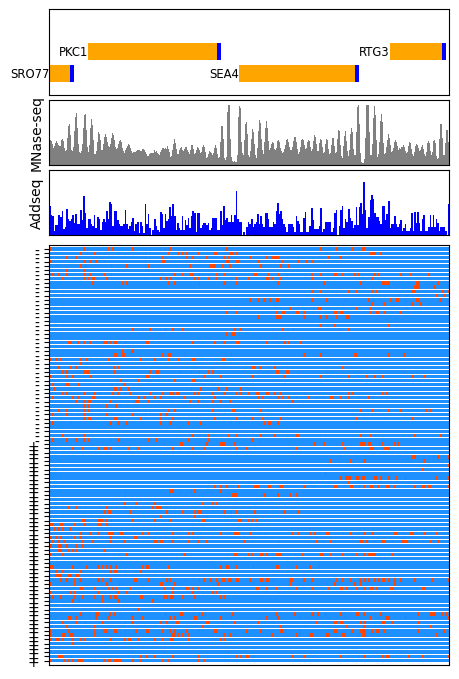

In [10]:
myprediction.plotTrack(prediction=prediction, gtfFile=gtfFile, refBdg=bdgFile, predBdg=predbdg, pregion=test_region, threashold=0.6)